# SVM

dataset: https://www.kaggle.com/datasets/ozguraslank/brain-stroke-ct-dataset?resource=download

Reference used to read dataset:
* https://www.kaggle.com/code/ozguraslank/reading-brain-stroke-ct-dataset


TEST MADES:
* SVC RB one vs one + standariced -> not converged 
* SVC Linear + standarice one vs rest  -> 125x125 did not converged after 20 min
* SVC Linear + standarice + pca(100 components) + one vs Rest 256x256 ->  converged but got bad results


RESULTS IN THIS NOTEBOOK:
* SVC Linear + standarice + pca(90%) + 256x256 

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.svm import LinearSVC #C-support vector Clasification
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
import os
import time
from PIL import Image
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix


## Data processing 

In [3]:
path = 'Brain_Stroke_CT_Dataset/'

#Path de las imágenes
normal_path = path + "Normal" + "/" + "PNG" #Debe ser así pa q funcione tipo expresion regular
ischemia_path = path + "Ischemia" + "/" + "PNG"
bleeding_path = path + "Bleeding" + "/" + "PNG"

#Path de las máscaras
ischemia_mask_path = path + "Ischemia" + "/" + "OVERLAY"
bleeding_mask_path = path + "Bleeding" + "/" + "OVERLAY"

#Obtenemos todas las imágenes
normal_folder = os.listdir(normal_path)
ischemia_folder = os.listdir(ischemia_path)
bleeding_folder = os.listdir(bleeding_path)

#Mostramos cantidad de datos por clase para ver desbalance
size_normal = len(normal_folder)
size_ischemia = len(ischemia_folder)
size_bleeding = len(bleeding_folder)
print("Normal:", size_normal)
print("Ischemia:", size_ischemia)
print("Bleeding:", size_bleeding)


Normal: 4427
Ischemia: 1130
Bleeding: 1093


In [4]:
def process_image(file_path, dim, scale):
    img = Image.open(file_path)
    img = img.convert(scale) #Escala de grises o RGB
    img = img.resize(dim) #Reescalamos
    img = np.array(img)
    return img.flatten()

In [5]:
#Almacenamos todas las imágenes
data = []
dim = (256, 256) #resize

folders = [normal_folder, ischemia_folder, bleeding_folder]
paths = [normal_path, ischemia_path, bleeding_path]

for i in range(len(folders)):

    #Recorremos todos los archivos de la carpeta y path i 
    for file_name in folders[i]:
        img = process_image(paths[i] + "/" + file_name, dim, 'L') #L = escala de grises
        data.append(img)


In [6]:
#Verificamos dimensión de los datos
data = np.array(data)
data.shape

(6650, 65536)

In [7]:
#Creamos el vector de labels
y = np.zeros(6650)
y[:size_normal] = 0 #Normal label [0:4427]
y[size_normal:size_normal+size_ischemia] = 1 #Ishcemia label [4427: 5557]
y[size_normal+size_ischemia:] = 2   #bleeding label [5557:]
y.shape

(6650,)

In [8]:
data.shape

(6650, 65536)

In [9]:
#Separamos en train y test
scaler = StandardScaler()
X_train, X_test, y_train, y_test = train_test_split(data, y, test_size=0.3, random_state=42)

#We Transform the data
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

#We do PCA
pca = PCA(n_components=0.90) #Nos quedamos con un 90% de la varianza
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)

In [12]:
print(X_train_pca.shape, X_test_pca.shape)

(4655, 670) (1995, 670)


### Image examples

PCA With normal images comparison

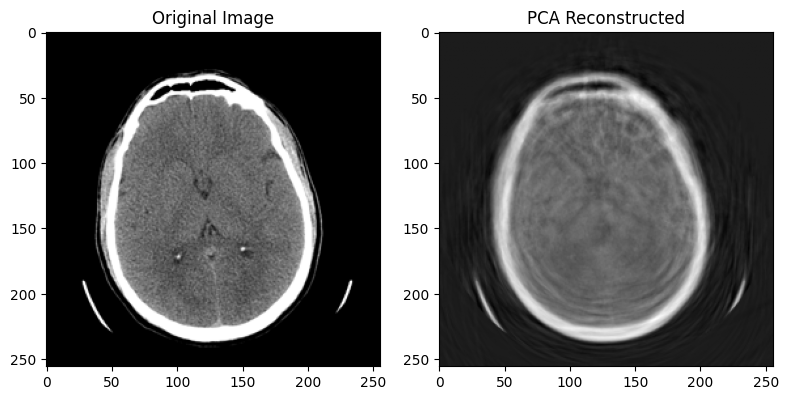

In [13]:
pca_transformed = X_train_pca[0]  # Shape: (n_components,)

#Volvemos a las dimensiones anteriores
reconstructed_scaled = pca.inverse_transform(pca_transformed.reshape(1, -1))

#Volvemos a los rangos de valores anteiores (desnormalizamos)
reconstructed_flat = scaler.inverse_transform(reconstructed_scaled)

#Reconstruimos desde un vector flatten a una imágen
reconstructed_image = reconstructed_flat.reshape(dim)

# Plot original and reconstructed
plt.figure(figsize=(8, 4))

# Original image
plt.subplot(1, 2, 1)
plt.imshow(X_train[0].reshape(dim), cmap='gray')
plt.title('Original Image')

# Reconstructed image
plt.subplot(1, 2, 2)
plt.imshow(reconstructed_image, cmap='gray')
plt.title('PCA Reconstructed')

plt.tight_layout()
plt.show()

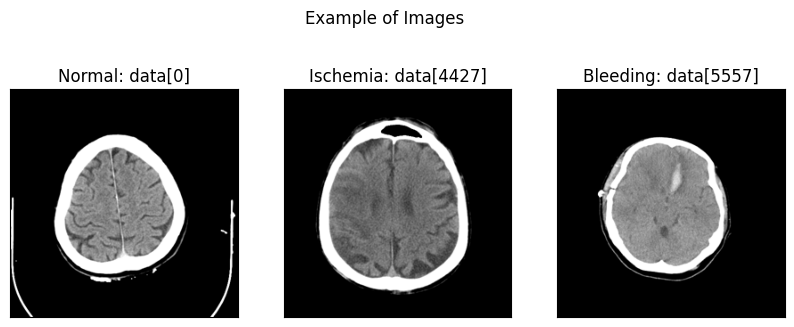

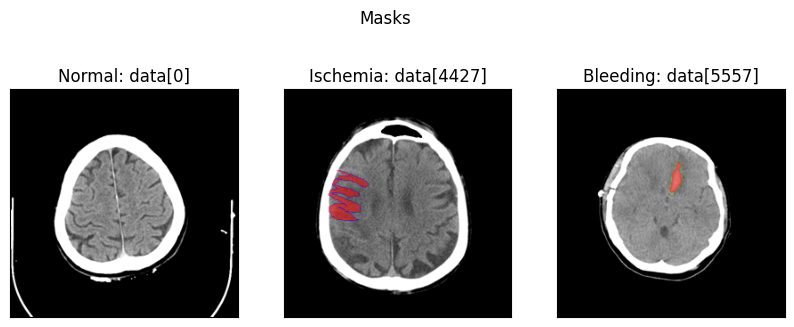

In [14]:
#Mostrmoas una imágen de ejemplo (para ver si el vector y está bien)
f, axes = plt.subplots(1, 3)
f.set_figheight(4)
f.set_figwidth(10)
f.suptitle("Example of Images")

axes[0].set_title("Normal: data[0]")
axes[0].imshow(data[0].reshape(dim), cmap="gray")
axes[0].set_xticks([])
axes[0].set_yticks([])

axes[1].set_title("Ischemia: data[4427]")
axes[1].imshow(data[4427].reshape(dim), cmap="gray")
axes[1].set_xticks([])
axes[1].set_yticks([])

axes[2].set_title("Bleeding: data[5557]")
axes[2].imshow(data[5557].reshape(dim), cmap="gray")
axes[2].set_xticks([])
axes[2].set_yticks([])
plt.show()


#We will also show the masks of the above pictures (manual)

data0_path =    normal_path    + "/10000.png"
data4427_path = ischemia_mask_path  + "/10003.png"
data5557_path = bleeding_mask_path  + "/10002.png"

mask_data0 = process_image(data0_path, dim, "RGB")
mask_data4427 = process_image(data4427_path, dim, "RGB")
mask_data5557 = process_image(data5557_path, dim, "RGB")


f, axes = plt.subplots(1, 3)
f.set_figheight(4)
f.set_figwidth(10)
f.suptitle("Masks")

axes[0].set_title("Normal: data[0]")
axes[0].imshow(mask_data0.reshape((dim[0], dim[1], 3)))
axes[0].set_xticks([])
axes[0].set_yticks([])

axes[1].set_title("Ischemia: data[4427]")
axes[1].imshow(mask_data4427.reshape((dim[0], dim[1], 3)))
axes[1].set_xticks([])
axes[1].set_yticks([])

axes[2].set_title("Bleeding: data[5557]")
axes[2].imshow(mask_data5557.reshape((dim[0], dim[1], 3)))
axes[2].set_xticks([])
axes[2].set_yticks([])
plt.show()


## SVM model

references: 
* https://www.geeksforgeeks.org/multi-class-classification-using-support-vector-machines-svm/
* https://scikit-learn.org/stable/modules/generated/sklearn.svm.LinearSVC.html

### Using one vs rest strategy

In [15]:
#Inicializamos el modelo SVM
svm_ovo = LinearSVC(random_state=42, max_iter=10000)

start_time = time.time()
svm_ovo.fit(X_train_pca, y_train)
end_time = time.time()

print("Training time:", end_time-start_time)


Training time: 770.3088276386261


c:\Users\basti\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\svm\_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


In [16]:
y_pred = svm_ovo.predict(X_test_pca)

# Accuracy
acc = accuracy_score(y_test, y_pred)
print(f"Accuracy: {acc:.4f}")

# Detailed report: precision, recall, F1
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=["Normal", "Ischemia", "Bleeding"]))

Accuracy: 0.8376

Classification Report:
              precision    recall  f1-score   support

      Normal       0.88      0.90      0.89      1347
    Ischemia       0.72      0.69      0.71       330
    Bleeding       0.74      0.70      0.72       318

    accuracy                           0.84      1995
   macro avg       0.78      0.77      0.77      1995
weighted avg       0.84      0.84      0.84      1995

